# Sentiment Analysis

In [122]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import enchant
import string
from pprint import pprint
from time import time
from wordcloud import WordCloud
from PIL import Image
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold

import warnings

warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /Users/donor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/donor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/donor/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/donor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Chargement et visualisation du jeu de données

In [23]:
df = pd.read_csv('reviews.csv')
df

,Rating,Year_Month,Reviewer_Location,Review_Text
0,5,2019-3,United Arab Emirates,"We've been to Disneyland Hongkong and Tokyo, s..."
1,4,2018-6,United Kingdom,I went to Disneyland Paris in April 2018 on Ea...
2,5,2019-4,United Kingdom,"What a fantastic place, the queues were decent..."
3,4,2019-4,Australia,We didn't realise it was school holidays when ...
4,5,missing,France,A Trip to Disney makes you all warm and fuzzy ...
...,...,...,...,...
13625,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...
13626,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...
13627,5,missing,South Africa,My eleven year old daughter and myself went to...
13628,4,missing,United States,"This hotel, part of the Disneyland Paris compl..."


## Exploration des données

#### Vérification des valeurs manquantes

In [24]:
df.isna().sum()

Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
dtype: int64

#### Contenu de la colonne Rating

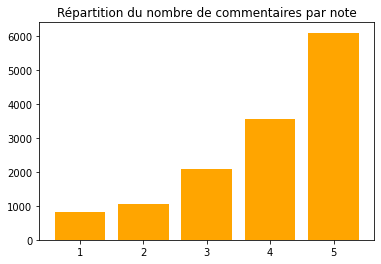

In [25]:
rating_count = df['Rating'].value_counts().sort_values(ascending=True)
plt.bar(range(1, 6), rating_count, color='orange')
plt.title('Répartition du nombre de commentaires par note');

#### Contenu de la colonne Review_Text

In [26]:
df['Review_Length'] = df['Review_Text'].str.split().map(lambda x: len(x))
df.sort_values(by='Review_Length', axis=0, ascending=True).head()

,Rating,Year_Month,Reviewer_Location,Review_Text,Review_Length
955,5,2018-8,France,ActiveX VT ERROR:,3
3566,5,2016-5,Saudi Arabia,ActiveX VT ERROR:,3
12686,4,2011-10,United Kingdom,everything was fantastic but food prices exces...,7
12440,3,2012-2,United Kingdom,Disappointed with size compared to florida cou...,7
12152,3,2012-1,United Kingdom,Mcdonalds style food but not the prices !!!!!!...,8


## Preprocessing de la colonne Review_text

On supprime les 2 reviews qui ont moins de 5 mots : ce sont des messages d'erreur

In [29]:
print(df[df['Review_Length'] < 5]['Review_Text'].values)
df = df[df['Review_Length'] > 5]

['ActiveX VT ERROR: ' 'ActiveX VT ERROR: ']


On choisit d'appliquer la stemmatisation plutôt que la lemmatisation car on obtient moins de mots et cela pallie au grand nombre de fautes d'orthographe.

In [33]:
PortStem = PorterStemmer()
EnglishDict = enchant.Dict("en")

def preprocess_reviews(review):
    # print('Unprocessed review: \n', review, '\n')
    review = review.replace('[^\w\s]', '')
    # print('Removing leading whitespace: \n', review, '\n')
    review = review.translate(str.maketrans("","",string.punctuation))
    # print('Removing punctuation: \n', review, '\n')
    review = re.sub('[\d]', '', review)
    # print('Removing digits: \n', review, '\n')
    review = review.lower()
    # print('Lowercasing: \n', review, '\n')
    tokens = word_tokenize(review)
    # print('Tokenising: \n', tokens, '\n')
    tokens = [token for token in tokens if token not in stop_words]
    # print('Removing stopwords: \n', tokens, '\n')
    tokens = [PortStem.stem(token) for token in tokens if len(token) > 2]
    # print('Lemmatising and keeping words more than 2 letters: \n', tokens, '\n')
    tokens = [token for token in tokens if EnglishDict.check(token)]
    # print('Keeping well written words: \n', tokens, '\n')
    processed_review = ' '.join(tokens)
    # print('Processed review: \n', processed_review, '\n')
    return processed_review

In [36]:
df['processed_review'] = df['Review_Text'].apply(lambda x: preprocess_reviews(x))
df.head()

,Rating,Year_Month,Reviewer_Location,Review_Text,Review_Length,processed_review
0,5,2019-3,United Arab Emirates,"We've been to Disneyland Hongkong and Tokyo, s...",91,far one best look forward visit biggest one da...
1,4,2018-6,United Kingdom,I went to Disneyland Paris in April 2018 on Ea...,176,went weekend know say cant date love mum went ...
2,5,2019-4,United Kingdom,"What a fantastic place, the queues were decent...",58,place queue decent best time year see almost b...
3,4,2019-4,Australia,We didn't realise it was school holidays when ...,148,school holiday went ride wait time disappoint ...
4,5,missing,France,A Trip to Disney makes you all warm and fuzzy ...,133,trip make warm actual kid big one make fun fil...
...,...,...,...,...,...,...
13625,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,173,went thought brilliant visit hotel stay bay al...
13626,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,191,adult child visit begin went night queue lot s...
13627,5,missing,South Africa,My eleven year old daughter and myself went to...,109,eleven year old daughter went visit son stay t...
13628,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",112,hotel part complex wonder place kid need room ...


### Résultat du processing

On peut voir ci-dessous que les phrases ont été correctement nettoyées de ponctuation, des chiffres, des mots de liaisons et articles... et stemmatisées.

Cette opération a permis d'économiser 57% du texte (en monbre de mots), ce qui réduit les ressources et le temps pour les traitements, et permet d'interpréter au mieux les textes.

In [37]:
df['Review_Length_preprocessed'] = df['processed_review'].str.split().map(lambda x: len(x))
df['diff'] = df['Review_Length_preprocessed'] - df['Review_Length']
df['diff'].describe()

count    13628.000000
mean      -110.385750
std        124.301651
min      -2694.000000
25%       -137.000000
50%        -73.000000
75%        -37.000000
max         -3.000000
Name: diff, dtype: float64

In [38]:
print(f"Exemple review positive (note de {df.loc[20, 'Rating']}) avant / après processing :\n")
print(df.loc[20, 'Review_Text'], '\n')
print(df.loc[20, 'processed_review'])

Exemple review positive (note de 5) avant / après processing :

This was my first trip to Disneyland Paris and it was absolutely fantastic! The staff were extremely helpful! The park was but this was to be expected with the time I visited. I would highly recommend this park! The character parade and end of day show are literally incredible!!  

first trip staff help park expect time visit would recommend park end day show liter


In [41]:
print(f"Exemple review avant / après processing :\n")
print(df.loc[17, 'Review_Text'])
print(df.loc[17, 'processed_review'])

Exemple review avant / après processing :

Why they selling fastpass tickets without have buy before the entrance tickets???  Any answer ???  Shame on you!!!   We came here from Greece until the entrance!!!  Avoid this place!!!                                                                                                                
sell ticket without buy ticket answer shame came avoid place


## Equilibrage des classes et polarisation

D'après le diagramme de répartition du nombre de reviews par classe généré au début, on constate que les classes correspondant au Rating est nettement en faveur des commentaires positifs (environ 2/3 - 1/3), ce qui crée un déséquilbre entre les deux classes à mesurer. Ce déséquilibre peut réduire la performance des modèles.

Nous avons opté pour faire un rééquilibrage de classes, pour maximiser la performances des modèles.

L'opération de polarisation permet de diviser le dataset en 2 classes pour la target.

In [42]:
def setClassBin(i):
    if i > 3:
        return 1
    else:
        return 0

In [43]:
df['polar'] = [setClassBin(x) for x in df.Rating]

0    3955
1    9673
Name: polar, dtype: int64


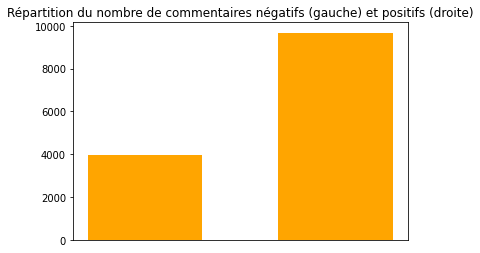

In [69]:
polar_count = df['polar'].value_counts().sort_values(ascending=True)
print(polar_count)

plt.bar(range(0,2), polar_count, color='orange', width = 0.6)
plt.xticks([])
plt.title('Répartition du nombre de commentaires négatifs (gauche) et positifs (droite)');

On se sert ensuite de la nouvelle colonne pour réduire le nombre de rating positifs au même nombre que les ratings négatifs.

In [45]:
df_eq = df[df['polar'] == 0]
df_eq = df_eq.append(df[df['polar'] == 1][:3955])
df_eq.polar.value_counts()

0    3955
1    3955
Name: polar, dtype: int64

## Visualisation de l'occurence des mots

Avec nos données propres, on peut savoir quels sont les mots qui dominent dans le corpus ainsi que dans les ratings positifs et négatifs.

### Series des mots les plus fréquents

Cette étape permet en premier lieu de connaître la fréquence exacte.
On utilise d'abord l'extracteur de features numériques CountVectoriser qui effectue une tokenisation puis un comptage.

In [47]:
CV = CountVectorizer(stop_words = 'english')
word_count = CV.fit_transform(df['processed_review'])
word_count = pd.DataFrame(word_count.toarray(), columns=CV.get_feature_names())
word_count = word_count.apply('sum', axis=0).sort_values(ascending=False)
word_count

park        23693
ride        20067
time        14762
day         13378
queue        8994
            ...  
hotelier        1
scrip           1
scrim           1
hostel          1
creator         1
Length: 5817, dtype: int64

On remarque que le mot park est très largement présent dans le corpus, ainsi que ride, time, day.
Nous extraierons ces mots dans certains wordclouds car ils ne permettent pas de différencier les reviews.

### Wordclouds

On créé une liste de mots que l'on voudra exclure car ils n'informent pas sur la polarité. On prend les 10 mots les plus présents et d'autres mots qui n'apportent pas beaucoup de sens tel que went, also.

In [61]:
excluded_words = set(list(word_count.index)[:10])
excluded_words.update(['really', 'get', 'went', 'one', 'would', 'also'])
excluded_words

{'also',
 'day',
 'food',
 'get',
 'good',
 'great',
 'one',
 'park',
 'queue',
 'really',
 'ride',
 'time',
 'visit',
 'wait',
 'went',
 'would'}

On fusionne le texte qu'on veut visualiser.

In [57]:
text = " ".join(review for review in df_eq.processed_review)
text_positive = " ".join(review for review in df_eq[df_eq['polar'] == 1].processed_review)
text_negative = " ".join(review for review in df_eq[df_eq['polar'] == 0].processed_review)

On créé 6 wordclouds :

- 1ere ligne : sans exclusion de mots
- 2eme ligne : avec exclusion

- 1ere colonne : toutes les reviews
- 2eme colonne : reviews positives
- 3eme colonne : reviews négatives

In [59]:
rose_mask = np.array(Image.open("mask.jpg"))

word_cloud = WordCloud(background_color = 'white', max_words=50, mask=rose_mask).generate(text)
word_cloud_positive = WordCloud(background_color = 'white', max_words=50, mask=rose_mask).generate(text_positive)
word_cloud_negative = WordCloud(background_color = 'white', max_words=50, mask=rose_mask).generate(text_negative)

word_cloud_2 = WordCloud(background_color = 'white', max_words=50, mask=rose_mask, stopwords=excluded_words).generate(text)
word_cloud_positive_2 = WordCloud(background_color = 'white', max_words=50, mask=rose_mask, stopwords=excluded_words).generate(text_positive)
word_cloud_negative_2 = WordCloud(background_color = 'white', max_words=50, mask=rose_mask, stopwords=excluded_words).generate(text_negative)

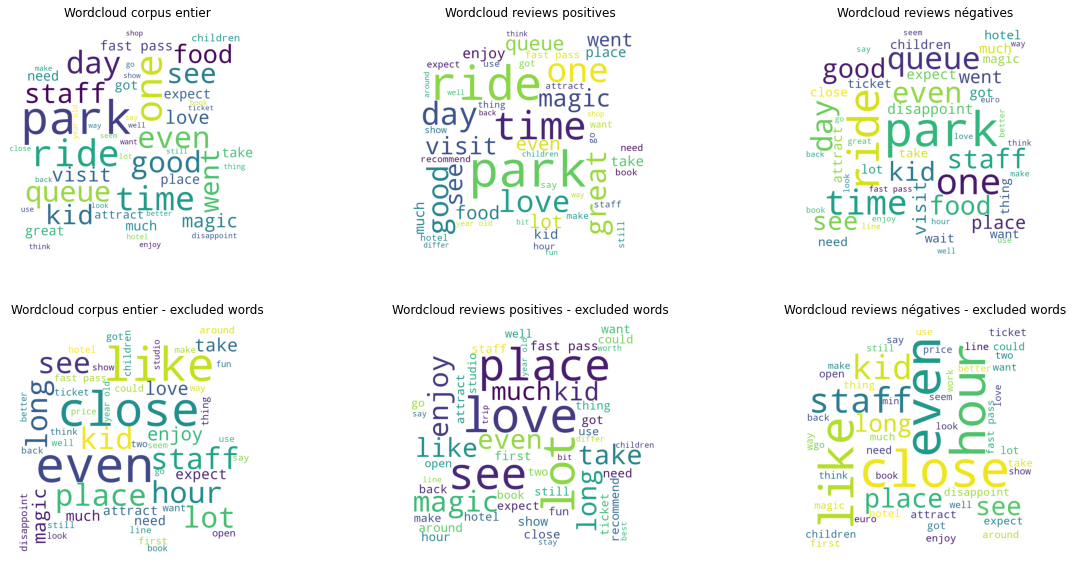

In [60]:
plt.figure(figsize=(20, 10))

plt.subplot(231)
plt.axis("off")
plt.imshow(word_cloud)
plt.title('Wordcloud corpus entier')

plt.subplot(232)
plt.axis("off")
plt.imshow(word_cloud_positive)
plt.title('Wordcloud reviews positives')

plt.subplot(233)
plt.axis("off")
plt.imshow(word_cloud_negative)
plt.title('Wordcloud reviews négatives')

plt.subplot(234)
plt.axis("off")
plt.imshow(word_cloud_2)
plt.title('Wordcloud corpus entier - excluded words')

plt.subplot(235)
plt.axis("off")
plt.imshow(word_cloud_positive_2)
plt.title('Wordcloud reviews positives - excluded words')

plt.subplot(236)
plt.axis("off")
plt.imshow(word_cloud_negative_2)
plt.title('Wordcloud reviews négatives - excluded words')
plt.show();

Sur la première ligne, les mêmes mots reviennent dans les reviews positives et négatives.
Sur la deuxième ligne, on peut distinguer plus de mots qui sont du registre positif et négatif.

## Séparation du jeu de données avec cross validation
On prépare le jeu de données avec 2 types de targets que nous utiliserons en fonction du nombre de classes à prédire
- y_5 : colonne originale contenant 5 classes
- y_2 : colonne polarisée avec 2 classes

In [86]:
X = df_eq['processed_review']
y_5 = df_eq['Rating']
y_2 = df_eq['polar']

In [77]:
folds = KFold(n_splits=5, shuffle=True, random_state=21)

1. Cross validation pour y_5

In [88]:
for train_index, test_index in folds.split(X, y_5):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_5_train, y_5_test = y_5.iloc[train_index], y_5.iloc[test_index]

2. Cross validation pour y_2

In [89]:
for train_index, test_index in folds.split(X, y_2):
    y_2_train, y_2_test = y_2.iloc[train_index], y_2.iloc[test_index]

On vérifie les dimensions

In [91]:
print('Dimensions données d\'entrainement: ', X_train.shape, y_5_train.shape, y_2_train.shape)
print('Dimensions données test :', X_test.shape, y_5_test.shape, y_2_test.shape)

Dimensions données d'entrainement:  (6328,) (6328,) (6328,)
Dimensions données test : (1582,) (1582,) (1582,)


## Implémentation de l'algorithme

On utilisera plusieurs algorithmes ainsi qu'un nombre de classes différent à prédire.

### Vectorisation
Cette étape est commune à tous nos algorithmes.
En effet, les reviews ne peuvent pas être données tel quel: l'algorithme a besoin de vecteurs numériques de longueur fixe plutôt que du texte brut à longueur variable.

In [92]:
CV = CountVectorizer(stop_words = 'english')
X_train_CV = CV.fit_transform(X_train)
X_test_CV = CV.transform(X_test)

On obtient ainsi la matrice suivante :

In [102]:
CV_df = pd.DataFrame(X_train_CV.toarray(), columns=CV.get_feature_names())
CV_df

,aah,ab,aback,abandon,abolish,abound,abroad,abrupt,absent,absorb,...,yum,yup,zap,zero,zigzag,zip,zipper,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1. Régression logistique (2 classes)

Il est intéressant de comparer la régression logistique au Complement Naive Bayes sur ce corpus de données, avec la fonction  StratifiedKFold pour créer les jeux de test / train, plus performant que le train_test_split, en partant des classes rééquilibrées (dataframe df_eq)

On vectorise le jeu de données, et on affiche la matrice de mots et ses dimensions.

In [ ]:
X_test_CV.shape

In [110]:
cv_df_log = pd.DataFrame(X_test_CV.toarray(), columns=CV.get_feature_names())
cv_df_log

,aah,ab,aback,abandon,abolish,abound,abroad,abrupt,absent,absorb,...,yum,yup,zap,zero,zigzag,zip,zipper,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
cv_df_log.shape

(1582, 4839)

Paramétrage du modèle :

In [115]:
Clist = [0.01, 0.05, 0.25, 0.5, 1, 1.25, 1.5, 2, 2.5, 3, 5]
Accs = []

for c in Clist:
    lr = LogisticRegression(C=c)
    lr.fit(X_test_CV, y_2_test)
    acc = accuracy_score(y_2_test, lr.predict(X_test_CV))
    Accs.append(acc)
    print ("Précision TEST pour C=%s: %s" % (c, acc))

# for c in Clist:
#     lr = LogisticRegression(C=c)
#     lr.fit(X_train_CV, y_2_train)
#     acc = accuracy_score(y_2_train, lr.predict(X_train_CV))
#     Accs.append(acc)
#     print ("Précision TRAIN pour C=%s: %s" % (c, acc))

Précision TEST pour C=0.01: 0.8419721871049305
Précision TEST pour C=0.05: 0.8969658659924147
Précision TEST pour C=0.25: 0.9450063211125158
Précision TEST pour C=0.5: 0.9620733249051833
Précision TEST pour C=1: 0.972819216182048
Précision TEST pour C=1.25: 0.97724399494311
Précision TEST pour C=1.5: 0.9810366624525917
Précision TEST pour C=2: 0.9867256637168141
Précision TEST pour C=2.5: 0.9867256637168141
Précision TEST pour C=3: 0.9879898862199747
Précision TEST pour C=5: 0.9943109987357776


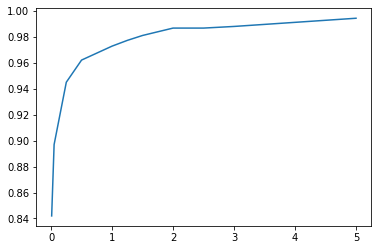

In [116]:
plt.plot(Clist,Accs)

le modèle est le plus optimal avec un hyper-paramètre C=5 (0,945) sur les données de test
Sur les données de Train, on est à 0,98

In [119]:
results = cross_val_score(LogisticRegression(), X_test_CV, y_2_test, scoring='accuracy', cv=5)
print("performances des folds :", results)
print("performance globale du modèle :", np.mean(cross_val_score(LogisticRegression(), X_test_CV, y_2_test, scoring='accuracy', cv=5)))

performances des folds : [0.73817035 0.76971609 0.78797468 0.7943038  0.7721519 ]
performance globale du modèle : 0.7724633630156131


In [120]:
y_pred_test = lr.predict(X_test_CV)
y_pred_train = lr.predict(X_train_CV)

Calcul et affichage de la matrice de confusion

In [123]:
matrice_confusion = confusion_matrix(y_2_test, y_pred_test)
print("Matrice de Confusion:\n",  matrice_confusion)

print("\nLe modèle a fait", matrice_confusion[0, 1], "Faux Positifs.")
print("\nLe modèle a fait", matrice_confusion[1, 0], "Faux Positifs.")

Matrice de Confusion:
 [[781   8]
 [  1 792]]

Le modèle a fait 8 Faux Positifs.

Le modèle a fait 1 Faux Positifs.


Calcul de l'accuracy, precision et rappel

In [124]:
(VN, FP), (FN, VP) = confusion_matrix(y_2_test, y_pred_test)
n = len(y_2_test)

print("\nModel Accuracy:", (VP + VN) / n)

print("\nModel Précision:", VP / (VP + FP))

print("\nModel Rappel:", VP / (VP + FN), "\n")

print("matrice de confusion TEST :\n",pd.crosstab(y_2_test, y_pred_test, rownames=['Realité'], colnames=['Prédiction']), "\n")
print("Classification report de train = \n", classification_report (y_2_train, y_pred_train))
print("Classification report de test = \n", classification_report (y_2_test, y_pred_test))


Model Accuracy: 0.9943109987357776

Model Précision: 0.99

Model Rappel: 0.9987389659520807 

matrice de confusion TEST :
 Prédiction    0    1
Realité             
0           781    8
1             1  792 

Classificationreport de train = 
               precision    recall  f1-score   support

           0       0.77      0.76      0.77      3166
           1       0.77      0.77      0.77      3162

    accuracy                           0.77      6328
   macro avg       0.77      0.77      0.77      6328
weighted avg       0.77      0.77      0.77      6328

Classificationreport de test = 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       789
           1       0.99      1.00      0.99       793

    accuracy                           0.99      1582
   macro avg       0.99      0.99      0.99      1582
weighted avg       0.99      0.99      0.99      1582



Après avoir utilisé KfoldStratifier & Corss_val_score : on remarque que modèle sature les ressources du serveur, et renvoie des warnings qui empêchent l'affichage (donc on empiètent sur les calculs) des résultats, ce qui les rend peu fiables.
Mais l'Accuracy globale affichée est de  de 0,8029

Train_test_split n'arrive pas à calculer le modèle.


### 2. Complement Naive Bayes (2 classes)

In [103]:
cnb = ComplementNB()
cnb.fit(X_train_CV, y_2_train)

ComplementNB()

In [104]:
print('Résultats Complement Naive Bayes données d\'entraînement :', cnb.score(X_train_CV, y_2_train))
print('Résultats Complement Naive Bayes données test :', cnb.score(X_test_CV, y_2_test))

Résultats Complement Naive Bayes données d'entraînement : 0.8629898862199747
Résultats Complement Naive Bayes données test : 0.8242730720606827


In [105]:
predicted_result = cnb.predict(X_test_CV)
print(classification_report(y_2_test, predicted_result))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       789
           1       0.80      0.86      0.83       793

    accuracy                           0.82      1582
   macro avg       0.83      0.82      0.82      1582
weighted avg       0.83      0.82      0.82      1582



*Interprétation des résultats*

On obtient un score d'environ 83% sur nos données test ce qui est environ 3% de moins que sur les données d'entraînement. Cela valide assez bien notre modèle mais il n'est pas aussi performant que la régression logistique.


### 3. Multinomial Naive Bayes

#### 3.1 CountVectorizer

In [125]:
clf = MultinomialNB()
clf.fit(X_train_CV, y_5_train)

MultinomialNB()

In [126]:
print('Résultats Multinomial Naive Bayes données d\'entraînement :', clf.score(X_train_CV, y_5_train))
print('Résultats Multinomial Naive Bayes données test :', clf.score(X_test_CV, y_5_test))

Résultats Multinomial Naive Bayes données d'entraînement : 0.6970606826801518
Résultats Multinomial Naive Bayes données test : 0.5221238938053098


In [127]:
predicted_result = clf.predict(X_test_CV)
print(classification_report(y_5_test, predicted_result))

              precision    recall  f1-score   support

           1       0.52      0.33      0.40       165
           2       0.29      0.18      0.22       201
           3       0.43      0.57      0.49       423
           4       0.32      0.19      0.24       253
           5       0.69      0.83      0.75       540

    accuracy                           0.52      1582
   macro avg       0.45      0.42      0.42      1582
weighted avg       0.49      0.52      0.50      1582



*Interprétation des résultats*

Le modèle est plus précis pour prédire les extrémités : 52% pour les notes de 1 et 69% pour les notes 5.
Cela montre les challenges de la classification de texte où les nuances sont difficiles à prendre en compte.

#### 3.2 TfidfVectorizer

In [128]:
TV = TfidfVectorizer(stop_words = 'english')

X_train_tfidf = TV.fit_transform(X_train)
X_test_tfidf = TV.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(6328, 4839)
(1582, 4839)


In [130]:
CV_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=TV.get_feature_names())

print('Ici les mots sont représentés par des floats car on ajoute un poids à chaque mot en fonction de sa fréquence.')
CV_tfidf

Ici les mots sont représentés par des floats car on ajoute un poids à chaque mot en fonction de sa fréquence.


,aah,ab,aback,abandon,abolish,abound,abroad,abrupt,absent,absorb,...,yum,yup,zap,zero,zigzag,zip,zipper,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
clf2 = MultinomialNB()

clf2.fit(X_train_tfidf, y_5_train)
print(clf2.score(X_train_tfidf, y_5_train))

print (clf2.score(X_test_tfidf, y_5_test))

0.513432364096081
0.4917825537294564


In [132]:
predicted_result_2 = clf2.predict(X_test_tfidf)
print(classification_report(y_5_test, predicted_result_2))

              precision    recall  f1-score   support

           1       1.00      0.01      0.02       165
           2       0.00      0.00      0.00       201
           3       0.40      0.62      0.49       423
           4       0.00      0.00      0.00       253
           5       0.56      0.95      0.70       540

    accuracy                           0.49      1582
   macro avg       0.39      0.32      0.24      1582
weighted avg       0.40      0.49      0.37      1582



*Interprétation des résultats*

On observe également une meilleure précision pour les notes extrêmes.

GridSearch nous permet de trouver les meilleurs paramètres pour un algorithme donné.

In [ ]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", LogisticRegression()),
    ]
)

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    "clf__max_iter": (20,),
    "clf__alpha": (0.00001, 0.000001),
    "clf__penalty": ("l2", "elasticnet"),
    # 'clf__max_iter': (10, 50, 80),
}

In [ ]:
# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)

t0 = time()
grid_search.fit(X, y)

print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

## Conclusion